In [3]:
# import xgboost
import pandas as pd
# from xgboost import XGBRegressor
import sklearn
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import random
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
import pyDOE2
import optuna
from tqdm import tqdm
import datetime
import time

import tensorflow as tf


import sys
sys.path.append('../structural')
import load_data

import importlib
importlib.reload(load_data)

<module 'load_data' from 'C:\\Users\\Lyle\\Documents\\DeCoDE\\DeCoDE-Bike-Project-Git\\Structural Analysis\\load_data.py'>

In [12]:
x_scaled, y, _, xscaler = load_data.load_framed_dataset("r", onehot = True, scaled = True, augmented = True)

yscaler = StandardScaler()
yscaler.fit(y)
y_scaled = yscaler.transform(y)
# y_scaled=pd.DataFrame(y_scaled, columns=y.columns, index=y.index)
x_scaled=x_scaled.values

In [15]:
''' 
Outermost Function Call for hyperparameter tuning. 
Takes in dataframe of optimization parameters, datasets, parameter names, algorithm name
Takes in reduction parameter for Generalized Subspace Design for grid search (reduction)
Takes in the number of retrainings for each hyperparameter config (n_trials), number of Cross Val splits (n_splits),
number of iterations to run BO (n_bo) number of instantiations of the final hyperparameter configuration to test
First, we set up a wrapper function for the call to fit_bo that we can use with Optuna.
Nest, we set up the pruner and the study, then perform the initial grid sampling. 
We then reset the sampler for our study to the TPESampler and perform BO to find the best hyperparameter configuration
Finally, we call preparDF, saving a report, and search for an optimal instantiation of a model to return.
'''    
def hyperparam_search(df, function, xdata, ydata, indexnames, name, reduction=1, n_trials = 10, n_splits = 5, n_bo=100, n_inst=100, multi=False):
    def wrapper(trial): #Wrapper function for fit_bo
        return fit_bo(trial, function, df, xdata, ydata, n_trials, n_splits, multi)
    start_time = time.time()
    pruner = optuna.pruners.PercentilePruner(75.0, n_startup_trials=1, n_warmup_steps=3, interval_steps=1) #Pruner
    study = optuna.create_study(direction="maximize", pruner=pruner)  # Create a new study using pruner.
    n_configs = init_gridsample(study, wrapper, df, reduction=reduction) #Perform initial grid sampling
    study.sampler = optuna.samplers.TPESampler() #Set sampler to Tree-Structured Parzen Estimator
    study.optimize(wrapper, n_trials=n_bo) #Optimize
    bestparams = study.best_params
    prepareDF(df, bestparams, indexnames, name)
    model, r2, mse, mae = test_instantiations(function, bestparams, xdata, ydata, names, n_inst, multi)    
    save_results(name, n_configs, reduction, n_trials, n_splits, n_bo, n_inst, start_time, r2, mse, mae)
    return model




'''
Perform the initialization of the BO using grid sampling.
First call get_configlist to get the list of grid sampling configurations
Then for each configuration, initialize a single point grid sample search in optuna
Run 1 trial for each grid point
'''
def init_gridsample(study, func, df, reduction=5):
    configs=get_configlist(df, reduction) # Get the DOE configurations
    for config in configs: #Loop over all DOE configs
        
        #Create the search space
        search_space={}
        for i in range(len(df.index)):
            search_space[df.index[i]]=[config[i]]
            
        #Set the study's sampler to be single point gridsearch space, then do one round of fitting
        study.sampler=optuna.samplers.GridSampler(search_space) 
        study.optimize(func, n_trials=1)
    return len(configs)
        
        
'''
Calculate gridsearch configurations. If we have a reduction greater than one, use GSD to reduce
For each configuration, calculate the corresponding parameter values using get_gridvalm then return
'''
def get_configlist(df, reduction=5):
    #Create a list of the number of grid locations for parameter. 
    #Cont & int get 2 locations, Cat gets locations equal to # of discrete categories
    configsize=[]
    for parameter in df.index: 
        if df.loc[parameter, "Datatype"]=="Categorical":
            configsize.append(len(df.loc[parameter, "Values/Min-Max"]))
        else:
            configsize.append(df.loc[parameter, "Gridres"])
        
    print("Grid Dimensionality:" + str(configsize))
    
    #If reduction>1 we call gsd, otherwise do full fact
    if reduction>1:
        DOEconfigs=pyDOE2.gsd(configsize, reduction=reduction)
    else:
        DOEconfigs=pyDOE2.fullfact(configsize).astype(int)
    print("Number of GridSearch configs: " + str(len(DOEconfigs)))
    
    #Look up actual gridsearch values from indices
    configvals=[]
    for i in range(len(DOEconfigs)):
        newvals=[]
        for j in range(len(DOEconfigs[0])):
            newvals.append(get_gridval(df, df.index[j], DOEconfigs[i][j]))
        configvals.append(newvals)
    return configvals


'''
Calculate the value of a particular grid sampling point 
Categorical, continuous, and discrete variables are handled individually
Log scale our calculations when the variable is log scaled
We assume grid points are evenly spaced between limits 
'''
def get_gridval(df, parameter, index):
    #If categorical, we simply return the value corresponidng to the index
    if df.loc[parameter, "Datatype"]=="Categorical":
        return df.loc[parameter, "Values/Min-Max"][index]
    
    #Grab vals for minval, maxval and scaling from df for convenience
    minval=df.loc[parameter, "Values/Min-Max"][0]
    maxval=df.loc[parameter, "Values/Min-Max"][1]
    scaling=df.loc[parameter, "Logscaling"]
    gridres=df.loc[parameter, "Gridres"]
    
    #Calculate the percentile between the parameter limits to sample the grid point
    gridloc=index/gridres+1/gridres/2
    
    #scaling is true, we will logscale when performing our calculations
    if scaling==True:
        #Indices 0 and 1 should be at 25th and 75th percentile of parameter ranges, respecively
        value=np.exp((1-gridloc)*np.log(minval)+gridloc*np.log(maxval))
    else:
        value=(1-gridloc)*minval+gridloc*maxval
            
    #If we have an integer parameter, we round to the nearest integer
    if df.loc[parameter, "Datatype"]=="Continuous":
        return value
    if df.loc[parameter, "Datatype"]=="Integer":
        return round(value)


        
'''
Sample a particular parameter from the optuna trial. 
Automates the sampling call based on the information about the parameter contained in DF

This function duals as a simple dictionary lookup if trial is a dictionary. 
This allows the reuse of fit_XXX functions when selecting an instantiation for a given config
'''
def sample(trial, df, parameter):
    #If we have passed in a dictionary, simply index a value from the dictionary. 
    if type(trial)==dict:
        return trial.get(parameter)
    
    #We setup each call to the trial in the format Optuna expects. See the Optuna docs
    if df.loc[parameter, "Datatype"]=="Categorical":
        return trial.suggest_categorical(parameter, df.loc[parameter, "Values/Min-Max"])
    #Grab vals for minval, maxval and scaling from df for convenience
    minval=df.loc[parameter, "Values/Min-Max"][0]
    maxval=df.loc[parameter, "Values/Min-Max"][1]
    scaling=df.loc[parameter, "Logscaling"]
    if df.loc[parameter, "Datatype"]=="Continuous":
        return trial.suggest_float(parameter, minval, maxval, log=scaling)
    if df.loc[parameter, "Datatype"]=="Integer":
        return trial.suggest_int(parameter, minval, maxval, 1, log=scaling)

    
'''
General BO fit loop. For each trial in BO we will create n_trials k_fold splits where k is n_splits
This yields a total of n_trial*n_folds fitting runs. 
Since we apply the hyperparameters to each model differently, we call the func function, which is specified
This func function will be a unique function for each type of model which will assign the hyperparameters
The func function will then fit the model and return the model back. For each run, we score on the val set.
We pass intermediate scores in a report to Optuna so it can determine if the trial should be pruned
If the trial is pruned, the trial prematurely exits
'''
def fit_bo(trial, func, df, xdata, ydata, n_trials, n_splits, multi=False):
    valr2=0
    stepcount=0
    with tqdm(total=n_splits*n_trials) as pbar: #Progress bar
        for j in range(n_trials): 
            kf=KFold(n_splits=n_splits, random_state=None, shuffle=False)
            for train_index, test_index in kf.split(xdata): # for each trial, loop over k-fold split
                x_train, x_val = xdata[train_index], xdata[test_index]
                y_train, y_val = ydata[train_index], ydata[test_index]
                '''
                Define a variant of the fit_bo function that splits the data into many single objective problem. 
                This is necessary for certain regressors such as xgboost. Sklearn's multi-output regressor doesnt 
                support eval sets in the kwargs since it doesnt automatically split them into separate sets.
                See https://github.com/scikit-learn/scikit-learn/issues/15953#issuecomment-944909955
                '''
                if multi==False: #If multi-output regressor
                    model=func(trial, df, x_train, x_val, y_train, y_val) #Call the specified model init+fit function
                    valpreds = model.predict(x_val)
                else: #If single-output regressor
                    valpreds=np.zeros(np.shape(y_val))
                    trainpreds=np.zeros(np.shape(y_train))
                    for output in range(len(y_train[0,:])):
                        y_train_so = y_train[:,output].copy()
                        y_val_so = y_val[:,output].copy()
                        model= func(trial, df, x_train, x_val, y_train_so, y_val_so)
                        valpreds[:,output] = model.predict(x_val)
                instancer2 = sklearn.metrics.r2_score(y_val, valpreds)
                valr2+=instancer2
                trial.report(valr2/(stepcount+1), stepcount) #Report scores for potential early pruning
                if trial.should_prune(): #Exit if Optuna decides to prune
                    raise optuna.exceptions.TrialPruned()
                pbar.update(1) #Update progress bar
                stepcount+=1
        return valr2/n_splits/n_trials 
    
    

def plot_res(study): #Some Optuna plots
    optuna.visualization.matplotlib.plot_param_importances(study)
    optuna.visualization.matplotlib.plot_intermediate_values(study)
    optuna.visualization.matplotlib.plot_optimization_history(study)
    optuna.visualization.matplotlib.plot_slice(study)
    
    
'''
Select an optimal instantiation of a model. 
We have defined a constant random seed to ensure train and val sets across all models are consistent
numtest models are tested, all instantiated using bestparams. 
If sklearn-like is true, the class probabilities are given by predict_proba and predict returns classes
Otherwise, predict returns probabilities and we need to round to get the classes. 
We handle these cases separately. We report R2, MSE, and MAE. 
Simlarly to fit_bo, we need to handle regressors that only deal with single variable outputs. See above. 
'''
def test_instantiations(func, bestparams, xdata, ydata, names, numtest=100, multi=False):
    x_train, x_val, y_train, y_val = train_test_split(xdata, ydata, test_size=0.2, random_state=1)
    bestr2=float("-inf")
    for i in tqdm(range(numtest)):
        if multi==False: #If multi-output regressor
            model = func(bestparams, None, x_train, x_val, y_train, y_val, True)
            valpreds = model.predict(x_val)
            trainpreds = model.predict(x_train)
        else: #If single-output regressor
            valpreds=np.zeros(np.shape(y_val))
            trainpreds=np.zeros(np.shape(y_train))
            for output in range(len(y_train[0,:])):
                y_train_so = y_train[:,output].copy()
                y_val_so = y_val[:,output].copy()
                model= func(bestparams, None, x_train, x_val, y_train_so, y_val_so)
                valpreds[:,output] = model.predict(x_val)
                trainpreds[:,output] = model.predict(x_train)
        valr2 = sklearn.metrics.r2_score(y_val, valpreds)
        if valr2>bestr2: # If this model has the best R2 so far, store its train and val set predictions
            bestr2 = valr2
            bestmodel = model
            bestvalpreds=valpreds
            besttrainpreds=trainpreds
    #Calculate some metrics
    r2=sklearn.metrics.r2_score(y_val, bestvalpreds)
    mse=sklearn.metrics.mean_squared_error(y_val, bestvalpreds)
    mae=sklearn.metrics.mean_absolute_error(y_val, bestvalpreds)
    print("R2: " + str(r2))
    print("MSE: " + str(mse))
    print("MAE: " + str(mae))
    plotperf(y_train, besttrainpreds, y_val, bestvalpreds, names) #Scatterplots
    return model, r2, mse, mae



def plotperf(y_train, y_pred_train, y_val, y_pred_val, names): # Plot predictions vs target values
    fig = plt.figure(figsize=(36,14))
    plt.rcParams.update({'font.size': 18})
    size=14
    linewidth=4
    x_subplots=5
    y_subplots=2
    scales=[100,100,100,100,100,100,180/np.pi,1,1,1]
    units=["cm", "cm", "cm", "cm", "cm", "cm", "deg", "N/A", "N/A", "Kg"]
    for i in range(len(y_val[0,:])):
        scale=scales[i]
        ax = fig.add_subplot(y_subplots, x_subplots, i+1)
        np.partition(y_pred_val[:,i].flatten(), -2)[-10]
        minval = min([y_pred_val[:,i].min(), y_pred_train[:,i].min()])
        maxval = max([np.partition(y_pred_val[:,i].flatten(), -2)[-5], np.partition(y_pred_val[:,i].flatten(), -2)[-5]])
        plt.xlim([0, maxval*scale*1.1])
        plt.ylim([0, maxval*scale*1.1])
        plt.scatter(y_train[:,i]*scale, y_pred_train[:,i]*scale, c="#FFB000", s=size, label='Train Data')
        plt.scatter(y_val[:,i]*scale, y_pred_val[:,i]*scale, c="#DC267F", s=size, label='Val. Data')
        plt.legend(loc='upper left')
        plt.title(names[i] + " (" + units[i] + ")")
        ax=add_identity(ax)
        ax.set_xlabel("Simulated Value")
        ax.set_ylabel("Predicted Value")
    fig.tight_layout()

def add_identity(axes, *line_args, **line_kwargs): #Helper function to draw target line on plots
    identity, = axes.plot([], [], *line_args, **line_kwargs, c="#888888")
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

'''
Print out a clean(ish) report of hyperparameter configurations
'''
def prepareDF(df, bestparams, indexnames, name):
    df = df.copy()
    df.columns=["Datatype", "Values/[Min, Max]", "Log Scaling", "Gridpoint Count"]
    df["Best Value"] = bestparams.values()
    pd.options.display.float_format = '{:,.2f}'.format 
    for index in df.index:
        if df.at[index, "Datatype"]=="Integer":
            df.at[index, "Best Value"]=int(df.at[index, "Best Value"])
    df.index=indexnames
    df.columns.name = "Hyperparameter"
    df.to_csv("Results/" + name + "_Regression.csv", index_label="Hyperparameter")
    print(df)
    
'''
Open Report DF and update results
'''
def save_results(name, n_configs, reduction, n_trials, n_splits, n_bo, n_inst, start_time, r2, mse, mae):
    df=pd.read_csv("Results/regression_results.csv", index_col=0)
#     df=pd.DataFrame()
    df[name]=[n_configs, reduction, n_trials, n_splits, n_bo, n_inst, r2, mse, mae, time.time()-start_time, str(datetime.datetime.now())]
    df.index=["n_configs", "reduction", "n_trials", "n_splits", "n_bo", "n_inst", "Coefficient of Determination (R2)", "Mean Squared Error (MSE)", "Mean Absolute Error (MAE)", "Execution Time (s)", "Finish Time"]
    df.to_csv("Results/regression_results.csv")

**Neural Network**

In [16]:
def create_dnn(ddims, ydims, DO, layers, layersize, batchnorm, activation): #DNN Builder function
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=ddims))

    for i in range(layers): #Add a dense layer for each layer in range(layers)
        model.add(tf.keras.layers.Dense(layersize)) #Dense layer with size equal to layersize
        if batchnorm=="True": # Add batchnorm if true
            model.add(tf.keras.layers.BatchNormalization())
        if activation=="ReLU": # Add relu or Leaky ReLU
            model.add(tf.keras.layers.ReLU())
        if activation=="Leaky ReLU":
            model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(DO)) #Add dropout with strength equal to DO
    
    model.add(tf.keras.layers.Dense(ydims))
    return model

'''
Fit function for NNs. 
Dropout, layers, layersize, batchnorm, and activation are passed to our DNN builder, create_dnn
Patience, classweight, and lr are used in fitting.
Fit and return the model
'''
def fit_NN(trial_or_dict, df, x_train, x_val, y_train, y_val, inst=False):

    batchsize = sample(trial_or_dict, df, "batchsize")
    patience = sample(trial_or_dict, df, "patience")
    dropout = sample(trial_or_dict, df, "dropout")
    lr = sample(trial_or_dict, df, "lr")
    layers = sample(trial_or_dict, df, "layers")
    batchnorm = sample(trial_or_dict, df, "batchnorm")
    activation = sample(trial_or_dict, df, "activation")
    layersize = sample(trial_or_dict, df, "layersize")
    model=create_dnn(len(x_train[0,:]), len(y_train[0,:]), dropout, layers, layersize, batchnorm, activation)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                          loss=tf.keras.losses.MeanSquaredError(),
                          metrics=['MSE'])
    model.fit(x=x_train, y=y_train, epochs=2000, batch_size=batchsize, validation_data=(x_val, y_val), callbacks=[callback], verbose=0)
    return model

#Create our dataframe of hyperparameters for NN fitting
df=pd.DataFrame()
df["batchsize"] = ["Integer", [32,1024], True, 2]
df["patience"] = ["Integer", [1,100], True, 2]
df["dropout"] = ["Continuous", [0.0,1.0], False, 2]
df["lr"] = ["Continuous", [1e-5, 0.1], True, 2]
df["layers"] = ["Integer", [1,6], False, 3]
df["batchnorm"] = ["Categorical", [False,True], False, "N/A"]
df["activation"] = ["Categorical", ["ReLU", "Leaky ReLU"], False, "N/A"]
df["layersize"] = ["Integer", [4,100], True, 3]
df = df.transpose()
df.columns=["Datatype", "Values/Min-Max", "Logscaling", "Gridres"]
NNdf = df

indexnames = ["Batch Size", "Early Stopping Patience", "Dropout Rate", "Learning Rate", "Number of Layers", "Include Batchnormalization", "Activation Function", "Layer Size"]
model = hyperparam_search(NNdf, fit_NN, x_scaled, y_scaled, indexnames, "NN", 5, 10, 5, 100, 100) #Find Hyperparams, save

[I 2022-08-30 08:21:16,969] A new study created in memory with name: no-name-80a8017a-a31d-4214-8511-4742b7f60c15


Grid Dimensionality:[2, 2, 2, 2, 3, 2, 2, 3]
Number of GridSearch configs: 100


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
  0%|                                                                                           | 0/50 [00:19<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
tf.keras.models.save_model(model, "./Trained Models/BestNN_Regressor")

**XGBoost**

[I 2022-04-21 17:35:56,518] A new study created in memory with name: no-name-6e4331c0-25af-4987-b3b9-459707a4ef48


Grid Dimensionality:[3, 3, 3, 3, 3, 3]
Number of GridSearch configs: 148


  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.16it/s]
[I 2022-04-21 17:36:39,857] Trial 0 finished with value: 0.3771013019986069 and parameters: {'depth': 3, 'lamb': 0.316227766016838, 'lr': 0.16666666666666666, 'gamma': 0.16666666666666666, 'min_child_weight': 0.8237744862210329, 'patience': 2}. Best is trial 0 with value: 0.3771013019986069.
  0%|                        

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:34<00:00,  1.89s/it]
[I 2022-04-21 17:48:19,060] Trial 18 finished with value: 0.4642813534833765 and parameters: {'depth': 3, 'lamb': 3.1622776601683804, 'lr': 0.5, 'gamma': 0.16666666666666666, 'min_child_weight': 0.8237744862210329, 'patience': 46}. Best is trial 2 with value: 0.5279901700749847.
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|█████████████████████████████████████

  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:46<00:00,  2.14s/it]
[I 2022-04-21 17:53:00,122] Trial 28 finished with value: 0.5651103187050704 and parameters: {'depth': 3, 'lamb': 31.62277660168379, 'lr': 0.16666666666666666, 'gamma': 0.16666666666666666, 'min_child_weight': 0.8237744862210329, 'patience': 46}. Best is trial 28 with value: 0.5651103187050704.
  0%|                     

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]
[I 2022-04-21 17:59:39,570] Trial 36 finished with value: 0.5501833059732097 and parameters: {'depth': 3, 'lamb': 31.62277660168379, 'lr': 0.5, 'gamma': 0.8333333333333333, 'min_child_weight': 2.23606797749979, 'patience': 10}. Best is trial 28 with value: 0.5651103187050704.
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|████████████████████████████████████████

  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
  6%|███████▌                                                                                                                       | 3/50 [00:07<01:50,  2.35s/it]
[I 2022-04-21 18:05:57,511] Trial 45 pruned. 
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and othe

  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.10it/s]
[I 2022-04-21 18:16:03,954] Trial 64 finished with value: 0.5240032170618585 and parameters: {'depth': 5, 'lamb': 3.1622776601683804, 'lr': 0.5, 'gamma': 0.5, 'min_child_weight': 2.23606797749979, 'patience': 2}. Best is trial 28 with value: 0.5651103187050704.
  0%|                                                       

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.36s/it]
[I 2022-04-21 18:20:27,937] Trial 73 finished with value: 0.4852019811153082 and parameters: {'depth': 5, 'lamb': 3.1622776601683804, 'lr': 0.8333333333333333, 'gamma': 0.5, 'min_child_weight': 6.069622310029172, 'patience': 46}. Best is trial 28 with value: 0.5651103187050704.
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
  6%|███████▌                              

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.62it/s]
[I 2022-04-21 18:30:25,859] Trial 82 finished with value: 0.5757930574428117 and parameters: {'depth': 5, 'lamb': 31.62277660168379, 'lr': 0.5, 'gamma': 0.16666666666666666, 'min_child_weight': 2.23606797749979, 'patience': 2}. Best is trial 80 with value: 0.5828959007375866.
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|████████████████████████████████████████

  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
  6%|███████▌                                                                                                                       | 3/50 [00:01<00:27,  1.69it/s]
[I 2022-04-21 18:46:22,307] Trial 100 pruned. 
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and oth

  6%|███████▌                                                                                                                       | 3/50 [00:02<00:41,  1.13it/s]
[I 2022-04-21 18:49:10,152] Trial 110 pruned. 
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
  6%|███████▌                                                                                                                       | 3/50 [00:07<01:52,  2.39s/it]
[I 2022-04-21 18:49:17,340] Trial 111 pruned. 
  0%|                                                           

  6%|███████▌                                                                                                                       | 3/50 [00:12<03:18,  4.22s/it]
[I 2022-04-21 19:03:04,499] Trial 129 pruned. 
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
  6%|███████▌                                                                                                                       | 3/50 [00:07<02:00,  2.57s/it]
[I 2022-04-21 19:03:12,216] Trial 130 pruned. 
  0%|                                                           

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.22it/s]
[I 2022-04-21 19:19:09,826] Trial 138 finished with value: 0.5730431768969667 and parameters: {'depth': 7, 'lamb': 31.62277660168379, 'lr': 0.5, 'gamma': 0.16666666666666666, 'min_child_weight': 0.8237744862210329, 'patience': 2}. Best is trial 134 with value: 0.5872983347894991.
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|████████████████████████████████████

  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.46it/s]
[I 2022-04-21 19:33:05,085] Trial 147 finished with value: 0.5436422838380034 and parameters: {'depth': 7, 'lamb': 31.62277660168379, 'lr': 0.8333333333333333, 'gamma': 0.8333333333333333, 'min_child_weight': 6.069622310029172, 'patience': 2}. Best is trial 134 with value: 0.5872983347894991.
100%|███████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.54s/it]
[I 2022-04-21 20:32:49,426] Trial 180 finished with value: 0.5927727722701361 and parameters: {'depth': 6, 'lamb': 69.73265206955406, 'lr': 0.2579486134759225, 'gamma': 0.33367774199099803, 'min_child_weight': 2.9102956630155585, 'patience': 4}. Best is trial 179 with value: 0.5959281060000217.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:24<00:00,  1.70s/it]
[I 2022-04-21 20:34:14,226] Trial 181 finished with value: 0.5955231614880032 and parameters: {'depth': 6, 'lamb': 65.24476823299307, 'lr': 0.2540265913801704, 'gamma': 0.3307112562451634, 'min_child_weight': 3.09200991659446, 'patience': 4}. Best is trial 179 with value: 0.5959281060000217.
100%|██████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:18<00:00,  1.58s/it]
[I 2022-04-21 20:58:41,471] Trial 198 finished with value: 0.5949488992303056 and parameters: {'depth': 6, 'lamb': 95.78927660092764, 'lr': 0.3217329943780427, 'gamma': 0.27910980439408756, 'min_child_weight': 3.627196203804085, 'patience': 5}. Best is trial 193 with value: 0.5972201958190652.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:22<00:00,  1.64s/it]
[I 2022-04-21 21:00:03,595] Trial 199 finished with value: 0.595663102896774 and parameters: {'depth': 6, 'lamb': 98.43955934883094, 'lr': 0.3167093329402583, 'gamma': 0.2607630258370529, 'min_child_weight': 3.526880965470941, 'patience': 5}. Best is trial 193 with value: 0.5972201958190652.
100%|███████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:35<00:00,  1.90s/it]
[I 2022-04-21 21:28:18,242] Trial 216 finished with value: 0.5945329968772546 and parameters: {'depth': 6, 'lamb': 82.52943398562091, 'lr': 0.29540648895215094, 'gamma': 0.20348738786130433, 'min_child_weight': 4.323604234608382, 'patience': 6}. Best is trial 211 with value: 0.5975739953196622.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:41<00:00,  2.02s/it]
[I 2022-04-21 21:29:59,263] Trial 217 finished with value: 0.5966788916726034 and parameters: {'depth': 6, 'lamb': 82.26349863574305, 'lr': 0.2807520548495541, 'gamma': 0.12847523124039667, 'min_child_weight': 3.9911515898966656, 'patience': 6}. Best is trial 211 with value: 0.5975739953196622.
100%|███████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:21<00:00,  1.64s/it]
[I 2022-04-21 21:56:04,468] Trial 234 finished with value: 0.5948557276997676 and parameters: {'depth': 6, 'lamb': 71.06154719930294, 'lr': 0.29921376915131515, 'gamma': 0.029303871162761105, 'min_child_weight': 5.44869968125541, 'patience': 7}. Best is trial 228 with value: 0.5987977432162784.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:41<00:00,  2.03s/it]
[I 2022-04-21 21:57:45,959] Trial 235 finished with value: 0.5981414853864221 and parameters: {'depth': 6, 'lamb': 71.03969045680115, 'lr': 0.2801465473468289, 'gamma': 0.12109248232908974, 'min_child_weight': 4.67728105801678, 'patience': 12}. Best is trial 228 with value: 0.5987977432162784.
100%|████████████████████████████████████████████████████████████████████████████

Hyperparameter                       Datatype Values/[Min, Max] Log Scaling  \
Maximum Tree Depth                    Integer            [2, 8]       False   
L2 Weight Regularization (lambda)  Continuous        [0.1, 100]        True   
Learning Rate (eta)                Continuous        [0.0, 1.0]       False   
Minimum Split Loss (gamma)         Continuous            [0, 1]       False   
Minimum Child Weight               Continuous         [0.5, 10]        True   
Early Stopping Patience               Integer          [1, 100]        True   

Hyperparameter                    Gridpoint Count  Best Value  
Maximum Tree Depth                              3        6.00  
L2 Weight Regularization (lambda)               3       72.41  
Learning Rate (eta)                             3        0.28  
Minimum Split Loss (gamma)                      3        0.06  
Minimum Child Weight                            3        4.82  
Early Stopping Patience                         3        8.00 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:20<00:00,  2.00s/it]


R2: 0.5954326105760395
MSE: 0.9775100309555302
MAE: 0.20753658243689177


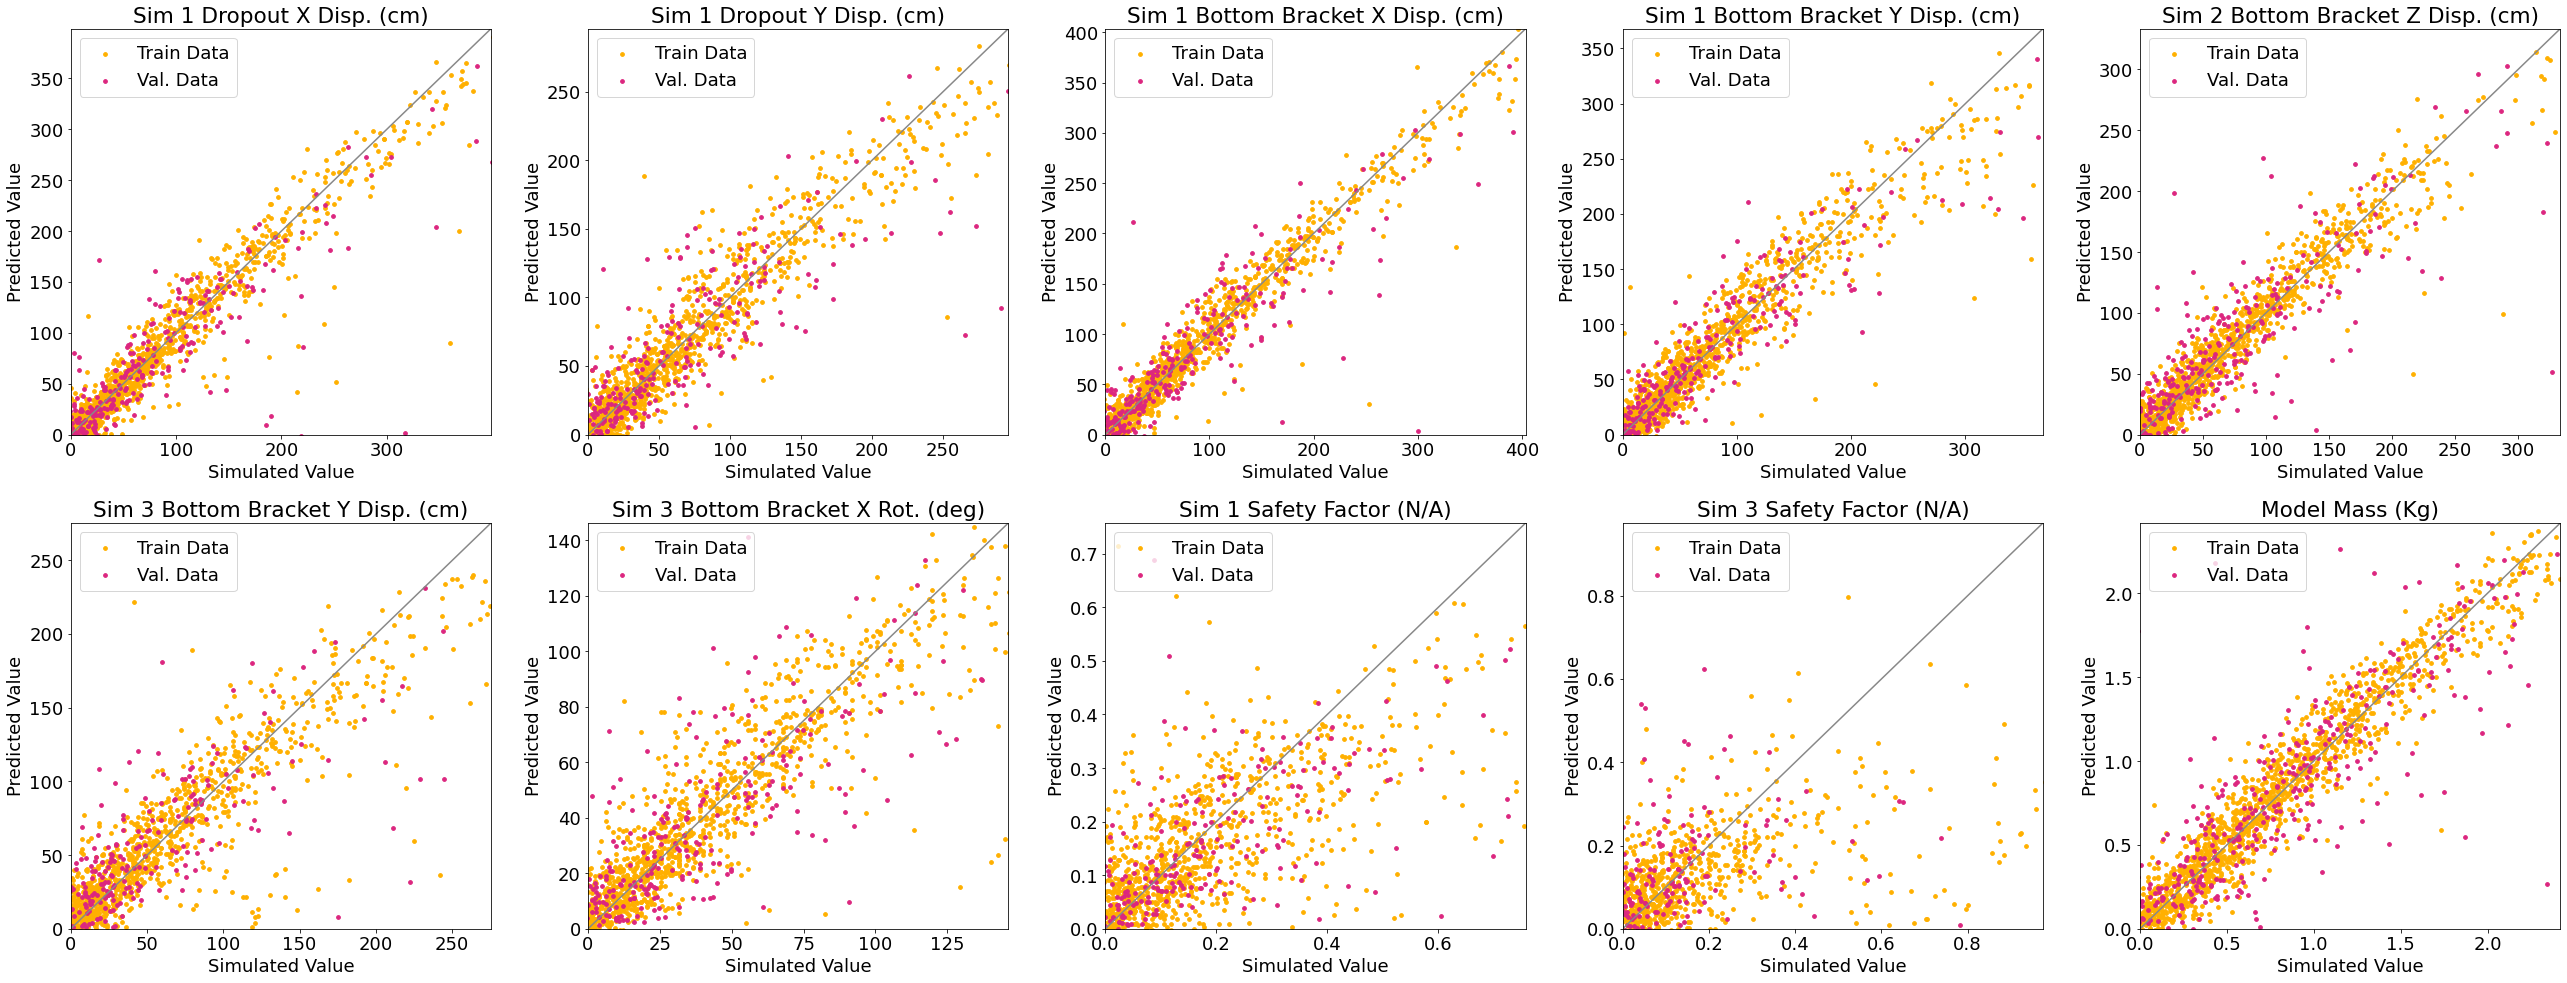

In [45]:
def fit_XGB(trial_or_dict, df, x_train, x_val, y_train, y_val, inst=False):
    depth = sample(trial_or_dict, df, "depth") #Max tree depth
    lamb = sample(trial_or_dict, df, "lamb") #L2 Regularization
    lr = sample(trial_or_dict, df, "lr") #eta in xgboost documentation (Learning rate)
    gamma = sample(trial_or_dict, df, "gamma")
    min_child_weight=sample(trial_or_dict, df, "min_child_weight")
    patience = sample(trial_or_dict, df, "patience")
    model = xgboost.XGBRegressor(eta=lr, reg_lambda=lamb, max_depth=depth, gamma=gamma, min_child_weight=min_child_weight)
    eval_set = [(x_val, y_val)]
    model.fit(x_train, y_train, eval_set=eval_set, verbose=0, early_stopping_rounds=patience)
    return model

#Create our dataframe of hyperparameters for XGB fitting
df=pd.DataFrame()
df["depth"] = ["Integer", [2,8], False, 3]
df["lamb"] = ["Continuous", [0.1,100], True, 3]
df["lr"] = ["Continuous", [0.0,1.0], False, 3]
df["gamma"] = ["Continuous", [0,1], False, 3]
df["min_child_weight"] = ["Continuous", [0.5,10], True, 3]
df["patience"] = ["Integer", [1,100], True, 3]
df = df.transpose()
df.columns=["Datatype", "Values/Min-Max", "Logscaling", "Gridres"]
XGBdf = df

indexnames = ["Maximum Tree Depth", "L2 Weight Regularization (lambda)", "Learning Rate (eta)", "Minimum Split Loss (gamma)", "Minimum Child Weight", "Early Stopping Patience"]
model = hyperparam_search(XGBdf, fit_XGB, x_scaled, y_scaled, indexnames, "XGB", 5, 10, 5, 100, 100, True) #Find Hyperparams, save

**KNeighbors**

[I 2022-04-21 17:27:27,574] A new study created in memory with name: no-name-9d02a53a-da7b-4b47-adce-941f2cf39ba3


Grid Dimensionality:[10, 2, 3]
Number of GridSearch configs: 60


  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.99it/s]
[I 2022-04-21 17:27:28,747] Trial 0 finished with value: -0.11528177520991953 and parameters: {'neighbors': 1, 'weights': 'uniform', 'distances': 'euclidean'}. Best is trial 0 with value: -0.11528177520991953.
  0%|                                                                                                           

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.76it/s]
[I 2022-04-21 17:28:14,119] Trial 18 finished with value: 0.2600041272916716 and parameters: {'neighbors': 355, 'weights': 'distance', 'distances': 'euclidean'}. Best is trial 16 with value: 0.31795270225223327.
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.55it/s]
[I 2022-04-21 17:28:48,603] Trial 28 finished with value: 0.24185976303251672 and parameters: {'neighbors': 355, 'weights': 'uniform', 'distances': 'manhattan'}. Best is trial 16 with value: 0.31795270225223327.
  0%|                                                                                                         

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 12.23it/s]
[I 2022-04-21 17:29:18,482] Trial 37 finished with value: 0.2960194477314544 and parameters: {'neighbors': 178, 'weights': 'distance', 'distances': 'manhattan'}. Best is trial 16 with value: 0.31795270225223327.
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.86it/s]
[I 2022-04-21 17:29:46,514] Trial 47 finished with value: 0.18923744162780537 and parameters: {'neighbors': 178, 'weights': 'uniform', 'distances': 'chebyshev'}. Best is trial 16 with value: 0.31795270225223327.
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
  6%|███████▌                                                                                                 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.61it/s]
[I 2022-04-21 17:30:03,923] Trial 57 finished with value: 0.20011068955647474 and parameters: {'neighbors': 178, 'weights': 'distance', 'distances': 'chebyshev'}. Best is trial 16 with value: 0.31795270225223327.
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
  6%|███████▌                                                                                                

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.35it/s]
[I 2022-04-21 17:31:45,496] Trial 97 finished with value: 0.31860877151625844 and parameters: {'neighbors': 76, 'weights': 'distance', 'distances': 'euclidean'}. Best is trial 64 with value: 0.31897563501881593.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.50it/s]
[I 2022-04-21 17:31:47,937] Trial 98 finished with value: 0.31874710153096314 and parameters: {'neighbors': 75, 'weights': 'distance', 'distances': 'euclidean'}. Best is trial 64 with value: 0.31897563501881593.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.11it/s]
[I 2022-04-21 17:31:50,701] Trial 99 finished with value: 0.30686308593802447 and pa

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.04it/s]
[I 2022-04-21 17:33:38,298] Trial 140 finished with value: 0.3120616368143031 and parameters: {'neighbors': 50, 'weights': 'distance', 'distances': 'euclidean'}. Best is trial 64 with value: 0.31897563501881593.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.53it/s]
[I 2022-04-21 17:33:40,735] Trial 141 finished with value: 0.31815310838614275 and parameters: {'neighbors': 68, 'weights': 'distance', 'distances': 'euclidean'}. Best is trial 64 with value: 0.31897563501881593.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.68it/s]
[I 2022-04-21 17:33:43,278] Trial 142 finished with value: 0.31812168636398497 and 

Hyperparameter          Datatype                  Values/[Min, Max]  \
Number of Neighbors      Integer                          [1, 1000]   
Neighbor Weighting   Categorical                [uniform, distance]   
Distance Metric      Categorical  [euclidean, manhattan, chebyshev]   

Hyperparameter      Log Scaling Gridpoint Count Best Value  
Number of Neighbors        True              10         70  
Neighbor Weighting        False             N/A   distance  
Distance Metric           False             N/A  euclidean  


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.89it/s]


R2: 0.30611884042216364
MSE: 1.2699605500312026
MAE: 0.41151459164255544


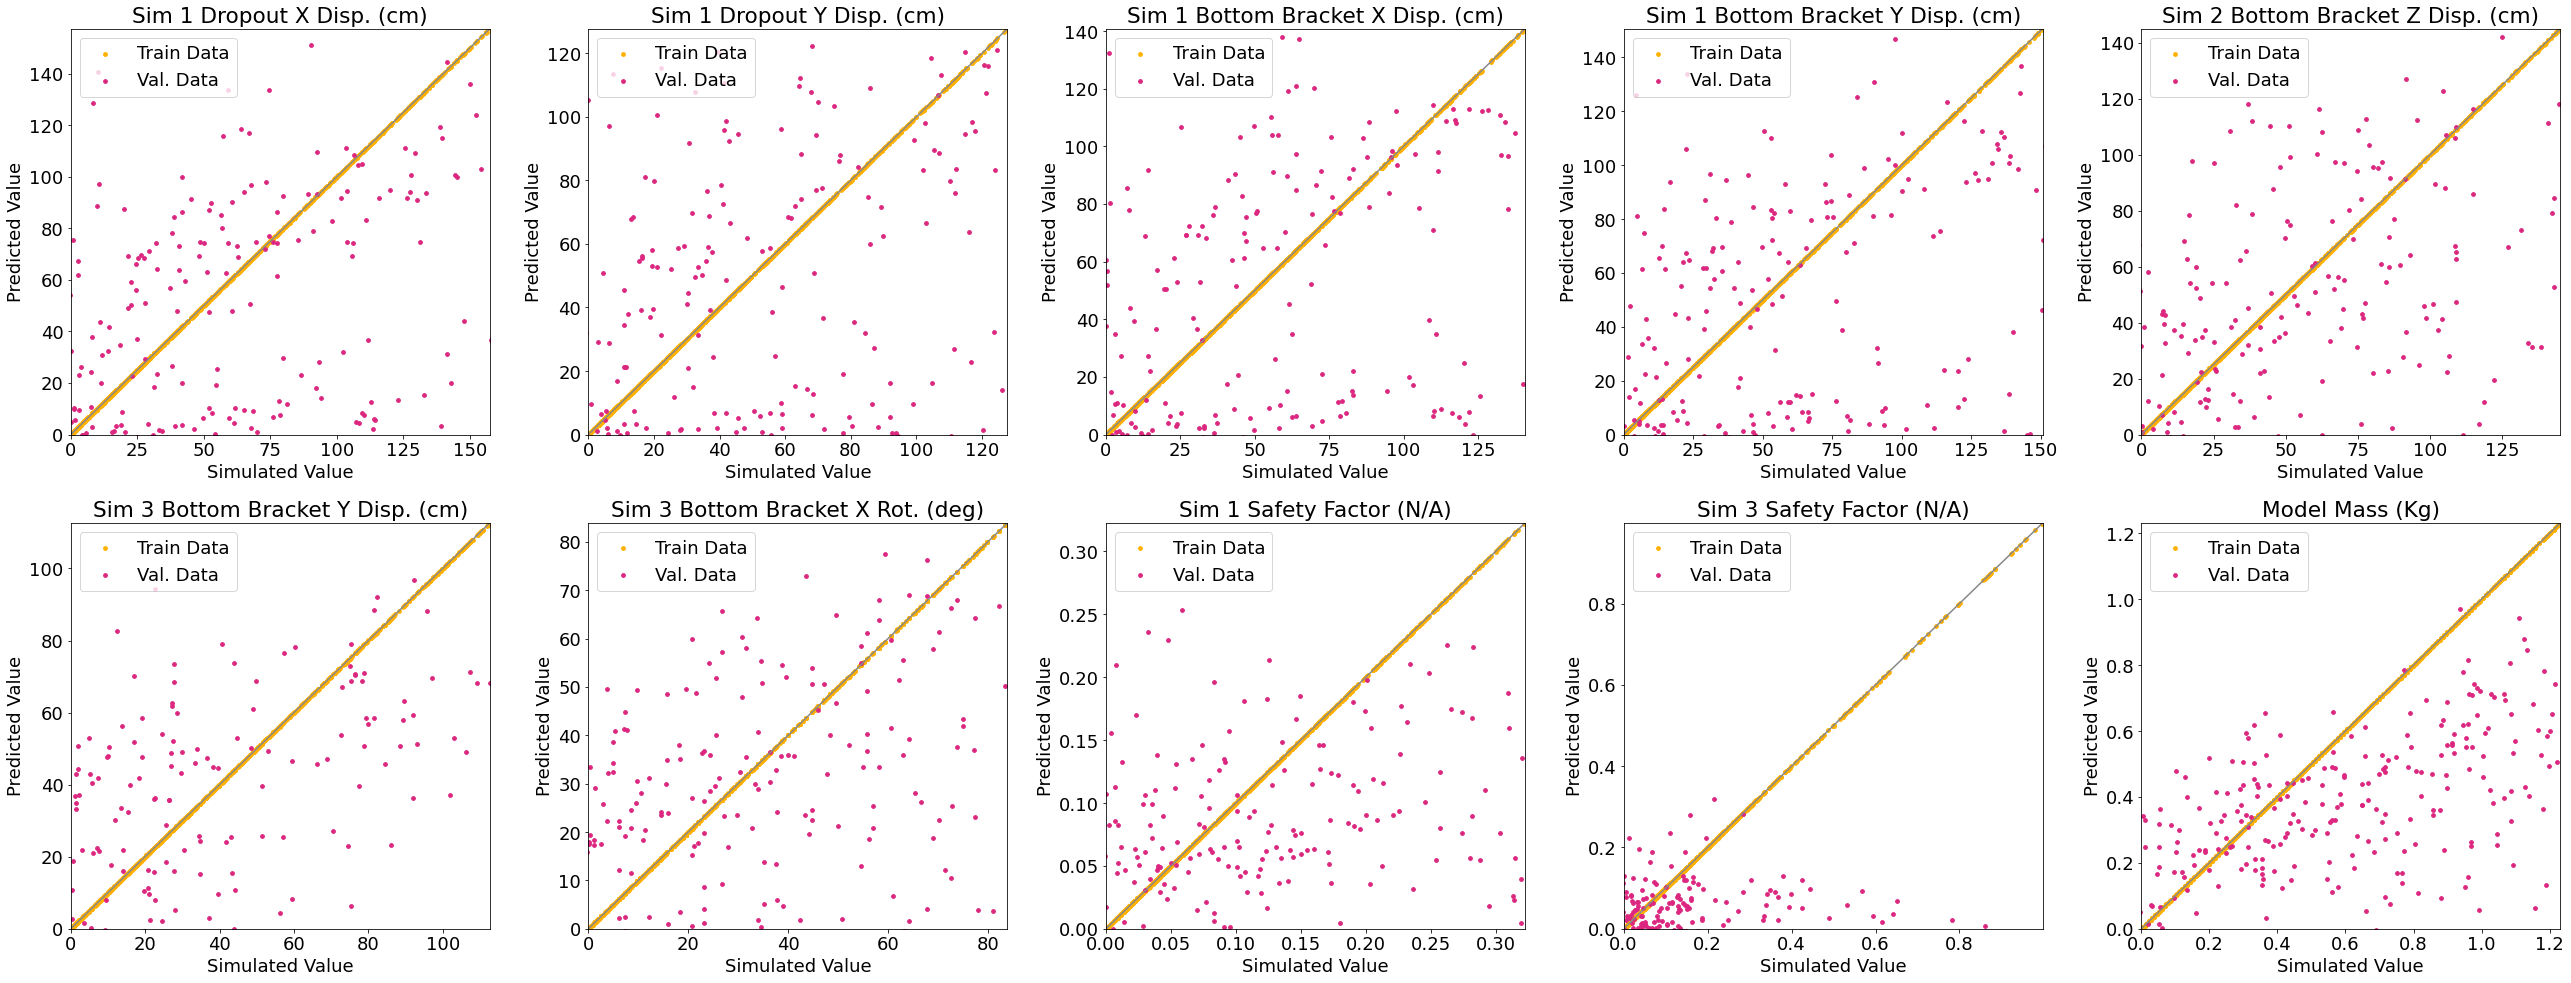

In [44]:
def fit_KNN(trial_or_dict, df, x_train, x_val, y_train, y_val, inst=False):
    neighbors = sample(trial_or_dict, df, "neighbors")
    weights = sample(trial_or_dict, df, "weights")
    distances = sample(trial_or_dict, df, "distances")
    model = KNeighborsRegressor(n_neighbors=neighbors, 
                                 weights=weights, 
                                 metric=distances)
    model.fit(x_train, y_train)
    return model

#Create our dataframe of hyperparameters for KNN fitting
df=pd.DataFrame()
df["neighbors"] = ["Integer", [1,1000], True, 10]
df["weights"] = ["Categorical", ["uniform", "distance"], False, "N/A"]
df["distances"] = ["Categorical", ["euclidean", "manhattan", "chebyshev"], False, "N/A"]
df=df.transpose()
df.columns=["Datatype", "Values/Min-Max", "Logscaling", "Gridres"]
KNNdf=df


indexnames = ["Number of Neighbors", "Neighbor Weighting", "Distance Metric"]
model = hyperparam_search(KNNdf, fit_KNN, x_scaled, y_scaled, indexnames, "KNN", 1) #Find Hyperparams, save

**Decision Tree**

[I 2022-04-23 14:41:24,201] A new study created in memory with name: no-name-9dcfe8c6-7121-4908-a36b-0e6de6ad2837


Grid Dimensionality:[5, 2, 3, 3, 3, 3]
Number of GridSearch configs: 162


  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 283.37it/s]
[I 2022-04-23 14:41:24,443] Trial 0 finished with value: 0.03720006304545606 and parameters: {'max_depth': 3, 'splitter': 'best', 'criterion': 'squared_error', 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 2}. Best is trial 0 with value: 0.03720006304545606.
  0%|                                         

  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 286.29it/s]
[I 2022-04-23 14:41:27,069] Trial 9 finished with value: 0.05819645538942553 and parameters: {'max_depth': 3, 'splitter': 'best', 'criterion': 'friedman_mse', 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': 2}. Best is trial 5 with value: 0.2237471102014807.
  0%|                                         

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.04it/s]
[I 2022-04-23 14:47:10,700] Trial 27 finished with value: 0.16965651300481394 and parameters: {'max_depth': 3, 'splitter': 'random', 'criterion': 'absolute_error', 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': 21}. Best is trial 10 with value: 0.25273894722900436.
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|█████████████████████████████████

  6%|███████▌                                                                                                                       | 3/50 [00:02<00:34,  1.38it/s]
[I 2022-04-23 14:47:16,711] Trial 37 pruned. 
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
  6%|███████▌                                                                                                                       | 3/50 [00:05<01:21,  1.74s/it]
[I 2022-04-23 14:47:21,944] Trial 38 pruned. 
  0%|                                                             

  6%|███████▌                                                                                                                      | 3/50 [00:00<00:00, 206.72it/s]
[I 2022-04-23 14:51:53,063] Trial 47 pruned. 
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 296.48it/s]
[I 2022-04-23 14:51:53,235] Trial 48 finished with value: 0.11961129905021903 and parameters: {'max_depth': 4, '

  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
  6%|███████▌                                                                                                                       | 3/50 [00:02<00:38,  1.21it/s]
[I 2022-04-23 14:53:36,140] Trial 57 pruned. 
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and othe

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 217.20it/s]
[I 2022-04-23 14:54:35,217] Trial 66 finished with value: 0.024246618612057978 and parameters: {'max_depth': 6, 'splitter': 'best', 'criterion': 'friedman_mse', 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 2}. Best is trial 41 with value: 0.32151179991312134.
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
  6%|███████▌                              

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:44<00:00,  4.48s/it]
[I 2022-04-23 15:06:36,331] Trial 75 finished with value: 0.3961329801311958 and parameters: {'max_depth': 6, 'splitter': 'best', 'criterion': 'absolute_error', 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 21}. Best is trial 75 with value: 0.3961329801311958.
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
  6%|███████▌                              

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 258.18it/s]
[I 2022-04-23 15:06:37,487] Trial 85 finished with value: 0.12255134729600799 and parameters: {'max_depth': 6, 'splitter': 'random', 'criterion': 'friedman_mse', 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 6}. Best is trial 75 with value: 0.3961329801311958.
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|███████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.48s/it]
[I 2022-04-23 15:11:06,081] Trial 94 finished with value: 0.2736255969806762 and parameters: {'max_depth': 6, 'splitter': 'random', 'criterion': 'absolute_error', 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 21}. Best is trial 75 with value: 0.3961329801311958.
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:56<00:00,  4.72s/it]
[I 2022-04-23 15:22:24,947] Trial 112 finished with value: 0.4182918242590013 and parameters: {'max_depth': 8, 'splitter': 'best', 'criterion': 'absolute_error', 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 21}. Best is trial 110 with value: 0.4250559539432632.
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|█████████████████████████████████████

 22%|███████████████████████████▌                                                                                                 | 11/50 [00:00<00:00, 238.93it/s]
[I 2022-04-23 15:26:20,921] Trial 121 pruned. 
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 233.99it/s]
[I 2022-04-23 15:26:21,139] Trial 122 finished with value: 0.1163152234550934 and parameters: {'max_depth': 8, 

  6%|███████▌                                                                                                                       | 3/50 [00:01<00:24,  1.89it/s]
[I 2022-04-23 15:29:27,023] Trial 130 pruned. 
  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
  6%|███████▌                                                                                                                      | 3/50 [00:00<00:00, 124.89it/s]
[I 2022-04-23 15:29:27,051] Trial 131 pruned. 
  0%|                                                           

  0%|                                                                                                                                       | 0/50 [00:00<?, ?it/s]C:\Users\Lyle\anaconda3\envs\tf27\lib\site-packages\optuna\distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 218.63it/s]
[I 2022-04-23 15:37:43,675] Trial 149 finished with value: 0.03751566792800604 and parameters: {'max_depth': 9, 'splitter': 'random', 'criterion': 'squared_error', 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 6}. Best is trial 110 with value: 0.4250559539432632.
  0%|                                    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:26<00:00,  5.33s/it]
[I 2022-04-23 16:30:18,004] Trial 172 finished with value: 0.42397626828126456 and parameters: {'max_depth': 7, 'splitter': 'best', 'criterion': 'absolute_error', 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': 26}. Best is trial 167 with value: 0.43239906144576185.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:35<00:00,  5.52s/it]
[I 2022-04-23 16:34:53,938] Trial 173 finished with value: 0.4283259568322723 and parameters: {'max_depth': 7, 'splitter': 'best', 'criterion': 'absolute_error', 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': 27}. Best is trial 167 with value: 0.43239906144576185.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [06:19<00:00,  7.58s/it]
[I 2022-04-23 18:07:15,691] Trial 190 finished with value: 0.4303452350664279 and parameters: {'max_depth': 7, 'splitter': 'best', 'criterion': 'absolute_error', 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 39}. Best is trial 167 with value: 0.43239906144576185.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [06:19<00:00,  7.59s/it]
[I 2022-04-23 18:13:35,361] Trial 191 finished with value: 0.4303452350664279 and parameters: {'max_depth': 7, 'splitter': 'best', 'criterion': 'absolute_error', 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 39}. Best is trial 167 with value: 0.43239906144576185.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [06:30<00:00,  7.81s/it]
[I 2022-04-23 19:58:56,313] Trial 208 finished with value: 0.43193337311735436 and parameters: {'max_depth': 7, 'splitter': 'best', 'criterion': 'absolute_error', 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 39}. Best is trial 167 with value: 0.43239906144576185.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:22<00:00,  6.45s/it]
[I 2022-04-23 20:04:18,886] Trial 209 finished with value: 0.4323578191869345 and parameters: {'max_depth': 7, 'splitter': 'best', 'criterion': 'absolute_error', 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 32}. Best is trial 167 with value: 0.43239906144576185.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:42<00:00,  6.85s/it]
[I 2022-04-23 21:34:41,677] Trial 226 finished with value: 0.43194524582117316 and parameters: {'max_depth': 7, 'splitter': 'best', 'criterion': 'absolute_error', 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 35}. Best is trial 225 with value: 0.4330562858926929.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:42<00:00,  6.85s/it]
[I 2022-04-23 21:40:24,342] Trial 227 finished with value: 0.4300371523303072 and parameters: {'max_depth': 7, 'splitter': 'best', 'criterion': 'absolute_error', 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 35}. Best is trial 225 with value: 0.4330562858926929.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:25<00:00,  6.52s/it]
[I 2022-04-23 23:07:51,785] Trial 245 finished with value: 0.43288142336112445 and parameters: {'max_depth': 7, 'splitter': 'best', 'criterion': 'absolute_error', 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 33}. Best is trial 225 with value: 0.4330562858926929.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:18<00:00,  6.37s/it]
[I 2022-04-23 23:13:10,275] Trial 246 finished with value: 0.43264900327486844 and parameters: {'max_depth': 7, 'splitter': 'best', 'criterion': 'absolute_error', 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 32}. Best is trial 225 with value: 0.4330562858926929.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████

Hyperparameter                          Datatype  \
Maximum Tree Depth                       Integer   
Splitting Strategy                   Categorical   
Split Quality Criterion              Categorical   
Min. Samples to Split Internal Node      Integer   
Min. Samples to Split Leaf Node          Integer   
Features Considered During Split         Integer   

Hyperparameter                                                   Values/[Min, Max]  \
Maximum Tree Depth                                                         [2, 10]   
Splitting Strategy                                                  [best, random]   
Split Quality Criterion              [squared_error, friedman_mse, absolute_error]   
Min. Samples to Split Internal Node                                        [2, 20]   
Min. Samples to Split Leaf Node                                            [1, 20]   
Features Considered During Split                                           [1, 39]   

Hyperparameter                  

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:37<00:00,  6.37s/it]


R2: 0.4401697808634948
MSE: 1.1558672580724147
MAE: 0.29670175474346233


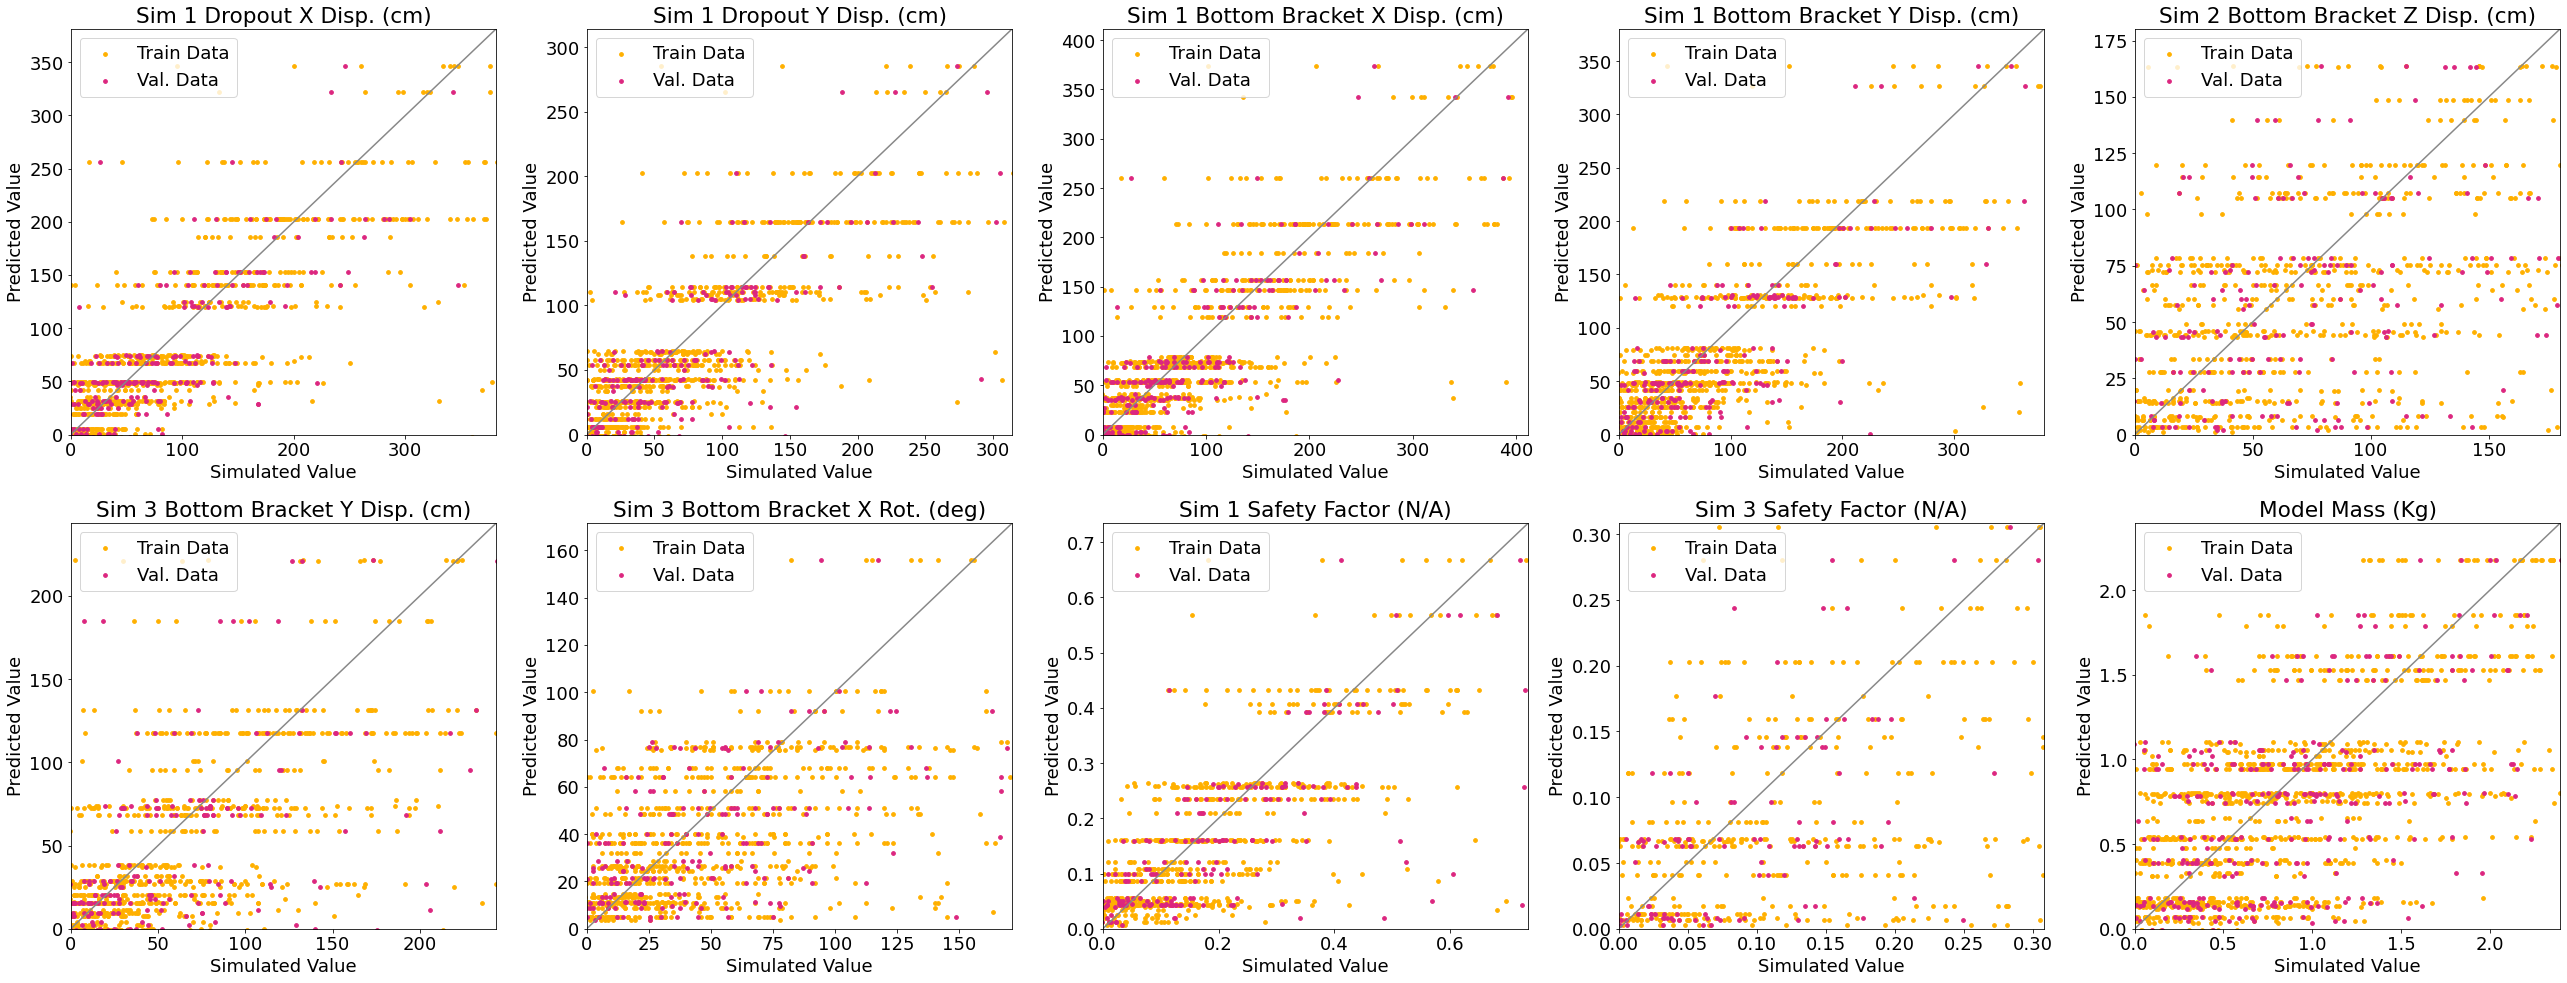

In [47]:
def fit_DT(trial_or_dict, df, x_train, x_val, y_train, y_val, inst=False):
    max_depth = sample(trial_or_dict, df, "max_depth")
    splitter = sample(trial_or_dict, df, "splitter")
    criterion = sample(trial_or_dict, df, "criterion")
    min_samples_split = sample(trial_or_dict, df, "min_samples_split")
    min_samples_leaf = sample(trial_or_dict, df, "min_samples_leaf")
    max_features = sample(trial_or_dict, df, "max_features")
    model = sklearn.tree.DecisionTreeRegressor(splitter=splitter, 
                            max_depth=max_depth, 
                            criterion=criterion,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            max_features=max_features,)
    model.fit(x_train, y_train)
    return model

#Create our dataframe of hyperparameters for SVM fitting
df=pd.DataFrame()
df["max_depth"] = ["Integer", [2,10], False, 5]
df["splitter"] = ["Categorical", ["best", "random"], False, "N/A"]
df["criterion"] = ["Categorical", ["squared_error","friedman_mse","absolute_error"], False, "N/A"]
df["min_samples_split"] = ["Integer", [2,20], True, 3]
df["min_samples_leaf"] = ["Integer", [1,20], True, 3]
df["max_features"] = ["Integer", [1,len(x_scaled[0])], True, 3]
df=df.transpose()
df.columns=["Datatype", "Values/Min-Max", "Logscaling", "Gridres"]
DTdf=df

indexnames=["Maximum Tree Depth", "Splitting Strategy", "Split Quality Criterion", "Min. Samples to Split Internal Node", "Min. Samples to Split Leaf Node", "Features Considered During Split"]
model = hyperparam_search(DTdf, fit_DT, x_scaled, y_scaled, indexnames, "DT", 5) #Find Hyperparams, save